In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("hojjatk/mnist-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/mnist-dataset


In [2]:
import numpy as np
import torch
from torch.utils.data import Dataset

# Fonction pour lire les fichiers IDX
def read_idx(filename):
    with open(filename, 'rb') as f:
        # Lire les en-têtes
        magic_number = int.from_bytes(f.read(4), byteorder='big')
        num_items = int.from_bytes(f.read(4), byteorder='big')
        if magic_number == 2051:  # Images
            rows = int.from_bytes(f.read(4), byteorder='big')
            cols = int.from_bytes(f.read(4), byteorder='big')
            data = np.frombuffer(f.read(), dtype=np.uint8).reshape(num_items, rows, cols)
        elif magic_number == 2049:  # Labels
            data = np.frombuffer(f.read(), dtype=np.uint8)
        else:
            raise ValueError("Invalid IDX file")
    return data

# Lire les données d'entraînement et de test
train_images_path = '/kaggle/input/mnist-dataset/train-images.idx3-ubyte'
train_labels_path = '/kaggle/input/mnist-dataset/train-labels.idx1-ubyte'
test_images_path = '/kaggle/input/mnist-dataset/t10k-images.idx3-ubyte'
test_labels_path = '/kaggle/input/mnist-dataset/t10k-labels.idx1-ubyte'




train_images = read_idx(train_images_path)
train_labels = read_idx(train_labels_path)
test_images = read_idx(test_images_path)
test_labels = read_idx(test_labels_path)


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [4]:
from torchvision import transforms

# Transformations pour MNIST (grayscale images)
transform = transforms.Compose([
    transforms.ToTensor(),  # Convertir en Tensor
    transforms.Normalize((0.5,), (0.5,))  # Normaliser (1 canal donc une valeur moyenne/écart-type)
])


In [5]:
class MNISTDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images  # Ne pas convertir en Tensor ici
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        
        # Appliquer les transformations, si spécifiées
        if self.transform:
            image = self.transform(image)
        
        return image, label


In [6]:
num_epochs = 200
batch_size = 32
learning_rate = 0.001

In [7]:

# Créer les datasets avec transformations
train_dataset = MNISTDataset(train_images, train_labels, transform=transform)
test_dataset = MNISTDataset(test_images, test_labels, transform=transform)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size,
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size,
                                         shuffle=False)

In [8]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

/opt/conda/lib/python3.10/site-packages/torchvision/transforms/functional.py:154: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_numpy.cpp:206.)
  img = torch.from_numpy(pic.transpose((2, 0, 1))).contiguous()


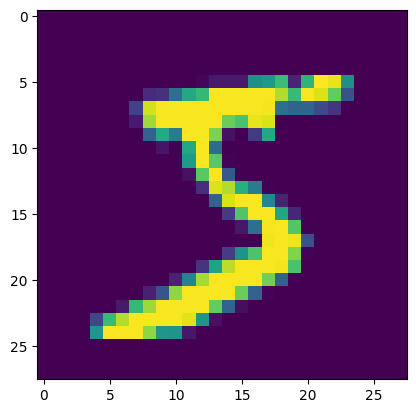

5

In [9]:
image,label=train_dataset[0]
image.shape
imshow(image)
label

In [10]:
# get some random training images
dataiter = iter(train_loader)
images, labels = next(dataiter)

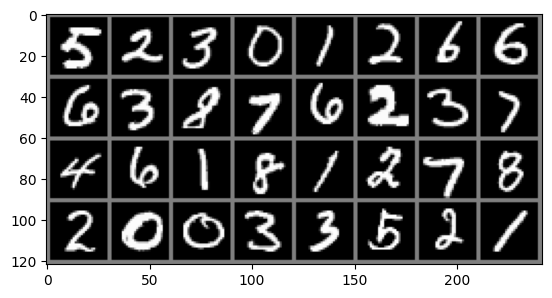

In [11]:
imshow(torchvision.utils.make_grid(images))


In [12]:
import torch.nn as nn
import torch.nn.functional as F

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        # Première couche de convolution
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)  # 28x28 -> 28x28, 16 canaux
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)  # 28x28 -> 14x14
        # Deuxième couche de convolution
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)  # 14x14 -> 14x14, 32 canaux
        # Couche entièrement connectée
        self.fc1 = nn.Linear(32 * 7 * 7, 128)  # 32 * 7 * 7 = 1568 entrées
        self.fc2 = nn.Linear(128, 10)  # 10 classes de sortie

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))  # Appliquer conv1 + relu + pooling
        x = self.pool(torch.relu(self.conv2(x)))  # Appliquer conv2 + relu + pooling
        x = x.view(-1, 32 * 7 * 7)  # Aplatir l'image pour passer à la couche entièrement connectée
        x = torch.relu(self.fc1(x))  # Appliquer la couche fc1
        x = self.fc2(x)  # Appliquer la couche fc2
        return x

In [13]:
model = ConvNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [14]:
train_loader

In [15]:
from tqdm import tqdm  # Pour afficher la barre de progression
n_total_steps = len(train_loader)


for epoch in range(num_epochs):
    # Afficher l'époque avant de commencer à entraîner sur les lots
    print(f"Epoch {epoch+1}/{num_epochs} started\n{'-'*30}")
    
    # Variable pour accumuler la perte totale pour cette époque
    epoch_loss = 0.0
    
    # Utilisation de tqdm pour afficher la barre de progression pour chaque époque
    for i, (images, labels) in enumerate(tqdm(train_loader, desc=f"Training...")):
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Accumuler la perte
        epoch_loss += loss.item()
    
    # Afficher la perte à la fin de l'époque
    avg_epoch_loss = epoch_loss / len(train_loader)  # Moyenne de la perte sur tous les lots
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {avg_epoch_loss:.4f}')



print('Finished Training')
PATH = './cnn.pth'
torch.save(model.state_dict(), PATH)

all_labels = []
all_predictions = []

with torch.no_grad():
    n_correct = 0
    n_samples = 0
    n_class_correct = [0 for i in range(10)]
    n_class_samples = [0 for i in range(10)]
    
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        
        # max returns (value, index)
        _, predicted = torch.max(outputs, 1)
        
        # Accumuler les étiquettes réelles et les prédictions
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())
        
        n_samples += labels.size(0)
        n_correct += (predicted == labels).sum().item()
        
        for i in range(len(labels)):
            label = labels[i]
            pred = predicted[i]
            if (label == pred):
                n_class_correct[label] += 1
            n_class_samples[label] += 1


    acc = 100.0 * n_correct / n_samples
    print(f'Accuracy of the network: {acc} %')

    for i in range(10):
        acc = 100.0 * n_class_correct[i] / n_class_samples[i]
        print(f'Accuracy of class {i}: {acc} %')
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

Epoch 1/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:09<00:00, 207.87it/s]


Epoch [1/200], Loss: 2.2024
Epoch 2/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 224.28it/s]


Epoch [2/200], Loss: 1.2946
Epoch 3/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 224.20it/s]


Epoch [3/200], Loss: 0.4888
Epoch 4/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 220.70it/s]


Epoch [4/200], Loss: 0.3436
Epoch 5/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 225.57it/s]


Epoch [5/200], Loss: 0.2858
Epoch 6/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 225.66it/s]


Epoch [6/200], Loss: 0.2485
Epoch 7/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 221.77it/s]


Epoch [7/200], Loss: 0.2204
Epoch 8/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 227.26it/s]


Epoch [8/200], Loss: 0.1977
Epoch 9/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 224.14it/s]


Epoch [9/200], Loss: 0.1791
Epoch 10/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 224.33it/s]


Epoch [10/200], Loss: 0.1635
Epoch 11/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 221.55it/s]


Epoch [11/200], Loss: 0.1506
Epoch 12/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 224.15it/s]


Epoch [12/200], Loss: 0.1397
Epoch 13/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 223.74it/s]


Epoch [13/200], Loss: 0.1303
Epoch 14/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 228.62it/s]


Epoch [14/200], Loss: 0.1218
Epoch 15/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 220.87it/s]


Epoch [15/200], Loss: 0.1149
Epoch 16/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 224.47it/s]


Epoch [16/200], Loss: 0.1083
Epoch 17/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 225.52it/s]


Epoch [17/200], Loss: 0.1030
Epoch 18/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 222.97it/s]


Epoch [18/200], Loss: 0.0982
Epoch 19/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 222.71it/s]


Epoch [19/200], Loss: 0.0938
Epoch 20/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 225.15it/s]


Epoch [20/200], Loss: 0.0896
Epoch 21/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 226.88it/s]


Epoch [21/200], Loss: 0.0865
Epoch 22/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 219.89it/s]


Epoch [22/200], Loss: 0.0832
Epoch 23/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 226.60it/s]


Epoch [23/200], Loss: 0.0802
Epoch 24/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 225.64it/s]


Epoch [24/200], Loss: 0.0774
Epoch 25/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 223.60it/s]


Epoch [25/200], Loss: 0.0748
Epoch 26/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 225.40it/s]


Epoch [26/200], Loss: 0.0728
Epoch 27/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 227.53it/s]


Epoch [27/200], Loss: 0.0705
Epoch 28/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 229.55it/s]


Epoch [28/200], Loss: 0.0686
Epoch 29/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 229.29it/s]


Epoch [29/200], Loss: 0.0667
Epoch 30/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 227.68it/s]


Epoch [30/200], Loss: 0.0651
Epoch 31/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 229.14it/s]


Epoch [31/200], Loss: 0.0634
Epoch 32/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 230.12it/s]


Epoch [32/200], Loss: 0.0620
Epoch 33/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 229.26it/s]


Epoch [33/200], Loss: 0.0605
Epoch 34/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 224.25it/s]


Epoch [34/200], Loss: 0.0588
Epoch 35/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 230.78it/s]


Epoch [35/200], Loss: 0.0578
Epoch 36/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 230.21it/s]


Epoch [36/200], Loss: 0.0569
Epoch 37/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 228.05it/s]


Epoch [37/200], Loss: 0.0555
Epoch 38/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 222.69it/s]


Epoch [38/200], Loss: 0.0545
Epoch 39/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 225.71it/s]


Epoch [39/200], Loss: 0.0533
Epoch 40/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 225.62it/s]


Epoch [40/200], Loss: 0.0524
Epoch 41/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 223.33it/s]


Epoch [41/200], Loss: 0.0513
Epoch 42/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 222.93it/s]


Epoch [42/200], Loss: 0.0504
Epoch 43/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 225.86it/s]


Epoch [43/200], Loss: 0.0495
Epoch 44/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 226.12it/s]


Epoch [44/200], Loss: 0.0487
Epoch 45/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 223.11it/s]


Epoch [45/200], Loss: 0.0477
Epoch 46/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 225.42it/s]


Epoch [46/200], Loss: 0.0471
Epoch 47/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 225.32it/s]


Epoch [47/200], Loss: 0.0462
Epoch 48/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 225.31it/s]


Epoch [48/200], Loss: 0.0456
Epoch 49/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 223.21it/s]


Epoch [49/200], Loss: 0.0448
Epoch 50/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 226.88it/s]


Epoch [50/200], Loss: 0.0441
Epoch 51/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 223.25it/s]


Epoch [51/200], Loss: 0.0435
Epoch 52/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 224.63it/s]


Epoch [52/200], Loss: 0.0428
Epoch 53/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 221.37it/s]


Epoch [53/200], Loss: 0.0424
Epoch 54/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 227.64it/s]


Epoch [54/200], Loss: 0.0416
Epoch 55/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 221.93it/s]


Epoch [55/200], Loss: 0.0409
Epoch 56/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 222.09it/s]


Epoch [56/200], Loss: 0.0406
Epoch 57/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 221.97it/s]


Epoch [57/200], Loss: 0.0398
Epoch 58/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 225.44it/s]


Epoch [58/200], Loss: 0.0395
Epoch 59/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 223.03it/s]


Epoch [59/200], Loss: 0.0388
Epoch 60/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 222.59it/s]


Epoch [60/200], Loss: 0.0383
Epoch 61/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 224.58it/s]


Epoch [61/200], Loss: 0.0377
Epoch 62/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 227.96it/s]


Epoch [62/200], Loss: 0.0372
Epoch 63/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 223.74it/s]


Epoch [63/200], Loss: 0.0369
Epoch 64/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 222.78it/s]


Epoch [64/200], Loss: 0.0364
Epoch 65/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 225.39it/s]


Epoch [65/200], Loss: 0.0358
Epoch 66/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 226.48it/s]


Epoch [66/200], Loss: 0.0355
Epoch 67/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 226.71it/s]


Epoch [67/200], Loss: 0.0352
Epoch 68/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 222.03it/s]


Epoch [68/200], Loss: 0.0347
Epoch 69/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 225.61it/s]


Epoch [69/200], Loss: 0.0343
Epoch 70/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 226.37it/s]


Epoch [70/200], Loss: 0.0340
Epoch 71/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 223.48it/s]


Epoch [71/200], Loss: 0.0334
Epoch 72/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 222.55it/s]


Epoch [72/200], Loss: 0.0330
Epoch 73/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 227.70it/s]


Epoch [73/200], Loss: 0.0326
Epoch 74/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 226.69it/s]


Epoch [74/200], Loss: 0.0324
Epoch 75/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 222.19it/s]


Epoch [75/200], Loss: 0.0320
Epoch 76/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 222.88it/s]


Epoch [76/200], Loss: 0.0317
Epoch 77/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 223.50it/s]


Epoch [77/200], Loss: 0.0313
Epoch 78/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 222.59it/s]


Epoch [78/200], Loss: 0.0309
Epoch 79/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 223.51it/s]


Epoch [79/200], Loss: 0.0307
Epoch 80/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 226.83it/s]


Epoch [80/200], Loss: 0.0302
Epoch 81/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 226.05it/s]


Epoch [81/200], Loss: 0.0299
Epoch 82/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 223.86it/s]


Epoch [82/200], Loss: 0.0297
Epoch 83/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 221.50it/s]


Epoch [83/200], Loss: 0.0293
Epoch 84/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 225.36it/s]


Epoch [84/200], Loss: 0.0290
Epoch 85/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 225.45it/s]


Epoch [85/200], Loss: 0.0287
Epoch 86/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 227.01it/s]


Epoch [86/200], Loss: 0.0283
Epoch 87/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 220.55it/s]


Epoch [87/200], Loss: 0.0281
Epoch 88/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 225.42it/s]


Epoch [88/200], Loss: 0.0278
Epoch 89/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 226.98it/s]


Epoch [89/200], Loss: 0.0274
Epoch 90/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 224.16it/s]


Epoch [90/200], Loss: 0.0273
Epoch 91/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 223.11it/s]


Epoch [91/200], Loss: 0.0270
Epoch 92/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 223.07it/s]


Epoch [92/200], Loss: 0.0266
Epoch 93/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 224.49it/s]


Epoch [93/200], Loss: 0.0265
Epoch 94/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 222.68it/s]


Epoch [94/200], Loss: 0.0262
Epoch 95/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 227.72it/s]


Epoch [95/200], Loss: 0.0258
Epoch 96/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 227.09it/s]


Epoch [96/200], Loss: 0.0256
Epoch 97/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 226.13it/s]


Epoch [97/200], Loss: 0.0254
Epoch 98/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 222.27it/s]


Epoch [98/200], Loss: 0.0251
Epoch 99/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 225.54it/s]


Epoch [99/200], Loss: 0.0249
Epoch 100/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 225.06it/s]


Epoch [100/200], Loss: 0.0246
Epoch 101/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 225.80it/s]


Epoch [101/200], Loss: 0.0244
Epoch 102/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 222.95it/s]


Epoch [102/200], Loss: 0.0240
Epoch 103/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 226.39it/s]


Epoch [103/200], Loss: 0.0237
Epoch 104/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 229.14it/s]


Epoch [104/200], Loss: 0.0237
Epoch 105/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 224.50it/s]


Epoch [105/200], Loss: 0.0233
Epoch 106/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 220.00it/s]


Epoch [106/200], Loss: 0.0231
Epoch 107/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 223.73it/s]


Epoch [107/200], Loss: 0.0228
Epoch 108/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 223.70it/s]


Epoch [108/200], Loss: 0.0226
Epoch 109/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 222.41it/s]


Epoch [109/200], Loss: 0.0226
Epoch 110/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 226.42it/s]


Epoch [110/200], Loss: 0.0223
Epoch 111/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 225.95it/s]


Epoch [111/200], Loss: 0.0221
Epoch 112/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 224.85it/s]


Epoch [112/200], Loss: 0.0220
Epoch 113/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 222.28it/s]


Epoch [113/200], Loss: 0.0215
Epoch 114/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 226.63it/s]


Epoch [114/200], Loss: 0.0215
Epoch 115/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 225.79it/s]


Epoch [115/200], Loss: 0.0211
Epoch 116/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 226.76it/s]


Epoch [116/200], Loss: 0.0211
Epoch 117/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 223.72it/s]


Epoch [117/200], Loss: 0.0207
Epoch 118/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 226.03it/s]


Epoch [118/200], Loss: 0.0206
Epoch 119/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 224.80it/s]


Epoch [119/200], Loss: 0.0204
Epoch 120/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 224.68it/s]


Epoch [120/200], Loss: 0.0202
Epoch 121/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 221.32it/s]


Epoch [121/200], Loss: 0.0201
Epoch 122/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 226.13it/s]


Epoch [122/200], Loss: 0.0199
Epoch 123/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 227.33it/s]


Epoch [123/200], Loss: 0.0196
Epoch 124/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 225.02it/s]


Epoch [124/200], Loss: 0.0195
Epoch 125/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 222.88it/s]


Epoch [125/200], Loss: 0.0193
Epoch 126/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 228.21it/s]


Epoch [126/200], Loss: 0.0190
Epoch 127/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 226.53it/s]


Epoch [127/200], Loss: 0.0190
Epoch 128/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 224.06it/s]


Epoch [128/200], Loss: 0.0189
Epoch 129/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 227.16it/s]


Epoch [129/200], Loss: 0.0186
Epoch 130/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 224.12it/s]


Epoch [130/200], Loss: 0.0183
Epoch 131/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 226.20it/s]


Epoch [131/200], Loss: 0.0182
Epoch 132/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 223.06it/s]


Epoch [132/200], Loss: 0.0181
Epoch 133/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 224.85it/s]


Epoch [133/200], Loss: 0.0178
Epoch 134/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 227.79it/s]


Epoch [134/200], Loss: 0.0178
Epoch 135/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 224.27it/s]


Epoch [135/200], Loss: 0.0176
Epoch 136/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 222.77it/s]


Epoch [136/200], Loss: 0.0174
Epoch 137/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 227.40it/s]


Epoch [137/200], Loss: 0.0173
Epoch 138/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 227.10it/s]


Epoch [138/200], Loss: 0.0171
Epoch 139/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 226.34it/s]


Epoch [139/200], Loss: 0.0169
Epoch 140/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 225.35it/s]


Epoch [140/200], Loss: 0.0168
Epoch 141/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 226.64it/s]


Epoch [141/200], Loss: 0.0166
Epoch 142/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 226.78it/s]


Epoch [142/200], Loss: 0.0164
Epoch 143/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 223.36it/s]


Epoch [143/200], Loss: 0.0164
Epoch 144/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 225.96it/s]


Epoch [144/200], Loss: 0.0161
Epoch 145/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 226.78it/s]


Epoch [145/200], Loss: 0.0159
Epoch 146/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 226.65it/s]


Epoch [146/200], Loss: 0.0159
Epoch 147/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 223.75it/s]


Epoch [147/200], Loss: 0.0157
Epoch 148/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 227.85it/s]


Epoch [148/200], Loss: 0.0156
Epoch 149/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 227.77it/s]


Epoch [149/200], Loss: 0.0155
Epoch 150/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 224.90it/s]


Epoch [150/200], Loss: 0.0153
Epoch 151/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 226.58it/s]


Epoch [151/200], Loss: 0.0152
Epoch 152/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 230.09it/s]


Epoch [152/200], Loss: 0.0151
Epoch 153/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 229.32it/s]


Epoch [153/200], Loss: 0.0149
Epoch 154/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 227.09it/s]


Epoch [154/200], Loss: 0.0148
Epoch 155/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 226.12it/s]


Epoch [155/200], Loss: 0.0148
Epoch 156/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 228.30it/s]


Epoch [156/200], Loss: 0.0144
Epoch 157/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 226.71it/s]


Epoch [157/200], Loss: 0.0143
Epoch 158/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 228.01it/s]


Epoch [158/200], Loss: 0.0142
Epoch 159/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 227.67it/s]


Epoch [159/200], Loss: 0.0141
Epoch 160/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 229.11it/s]


Epoch [160/200], Loss: 0.0139
Epoch 161/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 228.73it/s]


Epoch [161/200], Loss: 0.0138
Epoch 162/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 225.84it/s]


Epoch [162/200], Loss: 0.0137
Epoch 163/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 227.43it/s]


Epoch [163/200], Loss: 0.0135
Epoch 164/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 226.09it/s]


Epoch [164/200], Loss: 0.0134
Epoch 165/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 227.17it/s]


Epoch [165/200], Loss: 0.0133
Epoch 166/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 224.88it/s]


Epoch [166/200], Loss: 0.0131
Epoch 167/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 225.92it/s]


Epoch [167/200], Loss: 0.0131
Epoch 168/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 227.26it/s]


Epoch [168/200], Loss: 0.0129
Epoch 169/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 230.52it/s]


Epoch [169/200], Loss: 0.0128
Epoch 170/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 224.32it/s]


Epoch [170/200], Loss: 0.0128
Epoch 171/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 228.09it/s]


Epoch [171/200], Loss: 0.0126
Epoch 172/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 225.98it/s]


Epoch [172/200], Loss: 0.0123
Epoch 173/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 228.87it/s]


Epoch [173/200], Loss: 0.0123
Epoch 174/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 225.09it/s]


Epoch [174/200], Loss: 0.0122
Epoch 175/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 228.77it/s]


Epoch [175/200], Loss: 0.0122
Epoch 176/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 228.61it/s]


Epoch [176/200], Loss: 0.0121
Epoch 177/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 226.94it/s]


Epoch [177/200], Loss: 0.0120
Epoch 178/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 224.09it/s]


Epoch [178/200], Loss: 0.0118
Epoch 179/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 227.41it/s]


Epoch [179/200], Loss: 0.0118
Epoch 180/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 228.69it/s]


Epoch [180/200], Loss: 0.0115
Epoch 181/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 228.35it/s]


Epoch [181/200], Loss: 0.0115
Epoch 182/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 224.93it/s]


Epoch [182/200], Loss: 0.0113
Epoch 183/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 229.27it/s]


Epoch [183/200], Loss: 0.0111
Epoch 184/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 229.45it/s]


Epoch [184/200], Loss: 0.0112
Epoch 185/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 223.42it/s]


Epoch [185/200], Loss: 0.0111
Epoch 186/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 230.45it/s]


Epoch [186/200], Loss: 0.0109
Epoch 187/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 231.44it/s]


Epoch [187/200], Loss: 0.0109
Epoch 188/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 228.60it/s]


Epoch [188/200], Loss: 0.0107
Epoch 189/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 225.52it/s]


Epoch [189/200], Loss: 0.0107
Epoch 190/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 229.50it/s]


Epoch [190/200], Loss: 0.0105
Epoch 191/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 225.91it/s]


Epoch [191/200], Loss: 0.0105
Epoch 192/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 227.63it/s]


Epoch [192/200], Loss: 0.0103
Epoch 193/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 222.79it/s]


Epoch [193/200], Loss: 0.0103
Epoch 194/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 227.55it/s]


Epoch [194/200], Loss: 0.0102
Epoch 195/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 229.12it/s]


Epoch [195/200], Loss: 0.0101
Epoch 196/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 228.36it/s]


Epoch [196/200], Loss: 0.0101
Epoch 197/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 224.75it/s]


Epoch [197/200], Loss: 0.0099
Epoch 198/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 219.89it/s]


Epoch [198/200], Loss: 0.0099
Epoch 199/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 225.42it/s]


Epoch [199/200], Loss: 0.0098
Epoch 200/200 started
------------------------------


Training...: 100%|██████████| 1875/1875 [00:08<00:00, 216.22it/s]


Epoch [200/200], Loss: 0.0097
Finished Training
Accuracy of the network: 98.92 %
Accuracy of class 0: 99.38775510204081 %
Accuracy of class 1: 99.47136563876651 %
Accuracy of class 2: 98.44961240310077 %
Accuracy of class 3: 99.3069306930693 %
Accuracy of class 4: 99.4908350305499 %
Accuracy of class 5: 98.20627802690584 %
Accuracy of class 6: 98.43423799582463 %
Accuracy of class 7: 98.92996108949416 %
Accuracy of class 8: 98.66529774127311 %
Accuracy of class 9: 98.71159563924678 %


In [17]:
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

# Calcul des métriques globales
precision = precision_score(all_labels, all_predictions, average='weighted')
recall = recall_score(all_labels, all_predictions, average='weighted')
f1 = f1_score(all_labels, all_predictions, average='weighted')

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Confusion matrix
conf_matrix = confusion_matrix(all_labels, all_predictions)
print("Confusion Matrix:")
print(conf_matrix)

# Calcul des métriques par classe
class_precision = precision_score(all_labels, all_predictions, average=None)
class_recall = recall_score(all_labels, all_predictions, average=None)
class_f1 = f1_score(all_labels, all_predictions, average=None)

for i, (p, r, f) in enumerate(zip(class_precision, class_recall, class_f1)):
    print(f"Class {i}: Precision: {p:.4f}, Recall: {r:.4f}, F1 Score: {f:.4f}")


Precision: 0.9892
Recall: 0.9892
F1 Score: 0.9892
Confusion Matrix:
[[ 974    0    0    0    0    1    1    1    2    1]
 [   0 1129    1    0    1    1    1    1    1    0]
 [   2    0 1016    2    1    0    2    5    3    1]
 [   1    0    1 1003    0    1    0    0    2    2]
 [   0    0    0    0  977    0    1    0    0    4]
 [   2    0    0    7    0  876    4    1    0    2]
 [   4    3    1    0    1    4  943    0    2    0]
 [   0    1    4    1    0    0    0 1017    2    3]
 [   4    0    1    3    0    2    0    1  961    2]
 [   0    1    0    1    5    3    0    2    1  996]]
Class 0: Precision: 0.9868, Recall: 0.9939, F1 Score: 0.9903
Class 1: Precision: 0.9956, Recall: 0.9947, F1 Score: 0.9952
Class 2: Precision: 0.9922, Recall: 0.9845, F1 Score: 0.9883
Class 3: Precision: 0.9862, Recall: 0.9931, F1 Score: 0.9896
Class 4: Precision: 0.9919, Recall: 0.9949, F1 Score: 0.9934
Class 5: Precision: 0.9865, Recall: 0.9821, F1 Score: 0.9843
Class 6: Precision: 0.9905, Recall:

In [4]:
from PIL import Image
import numpy as np

class MNISTDataset1(torch.utils.data.Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images  # numpy.ndarray (ex: shape [N, H, W])
        self.labels = labels  # numpy.ndarray (ex: shape [N])
        self.transform = transform

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        # Convertir numpy.ndarray en PIL Image
        image = Image.fromarray(image)  # Assurez-vous que l'image est en format (H, W)

        # Appliquer les transformations
        if self.transform:
            image = self.transform(image)

        return image, label

    def __len__(self):
        return len(self.images)  # Retourne le nombre d'images dans le dataset



In [26]:
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torch import nn
from torch.utils.data import random_split



# Transformation des données MNIST
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Changer la taille de l'image pour correspondre à l'entrée de Faster R-CNN
    transforms.ToTensor(),
])

train_dataset = MNISTDataset1(train_images, train_labels, transform=transform)
test_dataset = MNISTDataset1(test_images, test_labels, transform=transform)




# Taille du sous-ensemble (20 % des données d'entraînement)
subset_size = int(len(train_dataset) * 0.2)

# Créer un sous-ensemble aléatoire (20% des données d'entraînement)
train_subset, _ = random_split(train_dataset, [subset_size, len(train_dataset) - subset_size])
test_subset, _ = random_split(test_dataset, [subset_size, len(test_dataset) - subset_size])

# DataLoader pour le sous-ensemble
train_loader = torch.utils.data.DataLoader(train_subset, batch_size=4, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_subset, batch_size=4, shuffle=False)

model = fasterrcnn_resnet50_fpn(pretrained=True)

num_classes = 11  # 10 classes + 1 pour l'arrière-plan
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [27]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Fonction pour créer les "targets" nécessaires pour Faster R-CNN
def create_target(image, label):
    target = {
        "boxes": torch.tensor([[10, 10, 214, 214]], dtype=torch.float32),  # La boîte englobante couvrant l'objet
        "labels": torch.tensor([label], dtype=torch.int64),  # Classe de l'objet
        "image_id": torch.tensor([0], dtype=torch.int64),  # Identifiant de l'image
    }
    return target


In [24]:
import torch
torch.cuda.empty_cache()


In [31]:
from tqdm import tqdm  # Pour afficher la barre de progression



import torch

for epoch in range(5):
    print(f"Epoch {epoch+1}/{3} started\n{'-'*30}")
    model.train()
    total_loss = 0
    for images, labels in tqdm(train_loader):
        images = images.to(device)
        labels = labels.to(device)
        targets = [create_target(img, label.item()) for img, label in zip(images, labels)]
        
        # Déplacer les targets sur le bon périphérique
        for target in targets:
            for key in target:
                target[key] = target[key].to(device)

        # Passer dans le modèle
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        total_loss += losses.item()

        # Optimisation
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        # Libérer la mémoire GPU après chaque lot
        torch.cuda.empty_cache()

    print(f'Epoch {epoch+1}, Total Loss: {total_loss}')



# Test
# Test
model.eval()
correct = 0
total = 0

# Variables pour suivre les résultats de la détection
all_labels = []
all_predictions = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Créer les targets pour Faster R-CNN
        targets = [create_target(img, label.item()) for img, label in zip(images, labels)]

        # Passer les images à travers le modèle Faster R-CNN
        prediction = model(images, targets)

        # Récupérer les labels prédites et les boxes
        predicted_labels = prediction[0]['labels']
        predicted_boxes = prediction[0]['boxes']

        # Comparer les prédictions avec les étiquettes réelles
        correct += (predicted_labels == labels).sum().item()  # Vérifier les classes
        total += labels.size(0)  # Nombre total d'images

        # Sauvegarder les étiquettes et les prédictions pour les métriques
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted_labels.cpu().numpy())

# Calcul de l'accuracy
accuracy = 100 * correct / total
print(f'Accuracy: {accuracy}%')

# Afficher l'accuracy pour chaque classe
for i in range(10):
    class_correct = (np.array(all_predictions) == i) & (np.array(all_labels) == i)
    class_accuracy = 100 * class_correct.sum() / (np.array(all_labels) == i).sum()
    print(f'Accuracy of class {i}: {class_accuracy} %')


Epoch 1/3 started
------------------------------


100%|██████████| 3000/3000 [20:39<00:00,  2.42it/s]


Epoch 1, Total Loss: 72.37298040138558
Epoch 2/3 started
------------------------------


100%|██████████| 3000/3000 [20:42<00:00,  2.41it/s]


Epoch 2, Total Loss: 30.728090470365714
Epoch 3/3 started
------------------------------


100%|██████████| 3000/3000 [20:38<00:00,  2.42it/s]


Epoch 3, Total Loss: 21.08315945378854
Epoch 4/3 started
------------------------------


100%|██████████| 3000/3000 [20:31<00:00,  2.44it/s]


Epoch 4, Total Loss: 15.832081995729823
Epoch 5/3 started
------------------------------


100%|██████████| 3000/3000 [20:30<00:00,  2.44it/s]


Epoch 5, Total Loss: 14.010008996039687


RuntimeError: The size of tensor a (2) must match the size of tensor b (4) at non-singleton dimension 0

In [38]:
model.eval()

correct = 0
total = 0
all_labels = []
all_predictions = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Créer les targets pour Faster R-CNN
        targets = [create_target(img, label.item()) for img, label in zip(images, labels)]

        # Passer les images à travers le modèle Faster R-CNN
        prediction = model(images, targets)

        # Récupérer les labels prédites, scores et boxes
        predicted_labels = prediction[0]['labels']
        predicted_scores = prediction[0]['scores']
        predicted_boxes = prediction[0]['boxes']

        # Filtrer les prédictions par un seuil de confiance
        threshold = 0.5
        high_confidence_mask = predicted_scores >= threshold
        predicted_labels = predicted_labels[high_confidence_mask]
        predicted_boxes = predicted_boxes[high_confidence_mask]

        # Comparer les prédictions avec les étiquettes réelles
        # Pour la détection d'objets, nous comparons par chaque boîte et étiquette
        # Utilisez une approche simplifiée pour cette démonstration
        for i, label in enumerate(labels):
            # Comparer les étiquettes de l'image avec les prédictions correspondantes
            predicted_class = predicted_labels[predicted_labels == label]
            correct += len(predicted_class)  # Nombre de prédictions correctes pour cette image
            total += 1  # Compter une image traitée

        # Sauvegarder les étiquettes et les prédictions pour les métriques
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted_labels.cpu().numpy())

# Calcul de l'accuracy
accuracy = 100 * correct / total
print(f'Accuracy: {accuracy}%')



Accuracy: 29.5%


Basé sur les résultats obtenus, avec une précision de 29,5 % pour le modèle Faster R-CNN contre 98,92 % pour le modèle CNN, il est évident que Faster R-CNN est mieux adapté aux tâches de détection d'objets, tandis que le CNN excelle dans les tâches de classification. De plus, j'ai constaté des difficultés lors de l'entraînement de Faster R-CNN, notamment en raison de sa complexité et de ses besoins élevés en ressources. Étant limité à seulement 5 époques pour l'entraînement, cela a également impacté les performances globales du modèle

In [11]:
# Transformation des données pour les adapter aux modèles préentraînés
import torch
import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torch import nn
from torch.utils.data import random_split
import torchvision.models as models
import torchvision.transforms as transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),         # Redimensionner à 224x224
    transforms.Grayscale(num_output_channels=3),  # Convertir en 3 canaux (RGB)
    transforms.ToTensor(),                 # Convertir en tenseur
    transforms.Normalize((0.5,), (0.5,))   # Normalisation
])

# Chargement du dataset MNIST
train_dataset = MNISTDataset1(train_images, train_labels, transform=transform)
test_dataset = MNISTDataset1(test_images, test_labels, transform=transform)

# Création des DataLoaders
train_loader = DataLoader(dataset=train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=64, shuffle=False)


In [12]:
num_classes = 10  # MNIST contient 10 classes (0 à 9)

# Charger VGG16 et remplacer la dernière couche
vgg16 = models.vgg16(pretrained=True)
vgg16.classifier[6] = nn.Linear(4096, num_classes)

# Charger AlexNet et remplacer la dernière couche
alexnet = models.alexnet(pretrained=True)
alexnet.classifier[6] = nn.Linear(4096, num_classes)


/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 212MB/s] 
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future.

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
from tqdm import tqdm  # Pour afficher la barre de progression

def train_model(model, train_loader, criterion, optimizer, num_epochs=5):
    model = model.to(device)
    for epoch in range(num_epochs):
        print(f"Epoch {epoch+1}/{num_epochs} started\n{'-'*30}")
        model.train()
        running_loss = 0.0
        for images, labels in tqdm(train_loader):
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

def test_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    print(f"Accuracy of the model on test data: {accuracy:.2f}%")
    return accuracy


In [15]:
# Critère de perte et optimiseur
import torch.nn as nn
import torch.optim as optim
criterion = nn.CrossEntropyLoss()

# Entraîner et tester VGG16
print("Training VGG16...")
optimizer_vgg16 = optim.Adam(vgg16.parameters(), lr=0.001)
train_model(vgg16, train_loader, criterion, optimizer_vgg16, num_epochs=5)
accuracy_vgg16 = test_model(vgg16, test_loader)

# Entraîner et tester AlexNet
print("Training AlexNet...")
optimizer_alexnet = optim.Adam(alexnet.parameters(), lr=0.001)
train_model(alexnet, train_loader, criterion, optimizer_alexnet, num_epochs=5)
accuracy_alexnet = test_model(alexnet, test_loader)


Training VGG16...
Epoch 1/5 started
------------------------------


100%|██████████| 938/938 [09:02<00:00,  1.73it/s]


Epoch [1/5], Loss: 0.3753
Epoch 2/5 started
------------------------------


100%|██████████| 938/938 [09:03<00:00,  1.72it/s]


Epoch [2/5], Loss: 0.1294
Epoch 3/5 started
------------------------------


100%|██████████| 938/938 [08:47<00:00,  1.78it/s]


Epoch [3/5], Loss: 0.0983
Epoch 4/5 started
------------------------------


100%|██████████| 938/938 [08:46<00:00,  1.78it/s]


Epoch [4/5], Loss: 0.0494
Epoch 5/5 started
------------------------------


100%|██████████| 938/938 [08:46<00:00,  1.78it/s]


Epoch [5/5], Loss: 0.0602
Accuracy of the model on test data: 98.60%
Training AlexNet...
Epoch 1/5 started
------------------------------


100%|██████████| 938/938 [01:55<00:00,  8.13it/s]


Epoch [1/5], Loss: 0.3846
Epoch 2/5 started
------------------------------


100%|██████████| 938/938 [01:56<00:00,  8.05it/s]


Epoch [2/5], Loss: 0.1219
Epoch 3/5 started
------------------------------


100%|██████████| 938/938 [01:56<00:00,  8.08it/s]


Epoch [3/5], Loss: 0.1078
Epoch 4/5 started
------------------------------


100%|██████████| 938/938 [01:56<00:00,  8.08it/s]


Epoch [4/5], Loss: 0.1068
Epoch 5/5 started
------------------------------


100%|██████████| 938/938 [01:56<00:00,  8.09it/s]


Epoch [5/5], Loss: 0.0883
Accuracy of the model on test data: 98.04%



Les résultats obtenus montrent que les modèles préentraînés, comme VGG16 et AlexNet, atteignent une précision élevée sur le dataset MNIST (98.60% et 98.04% respectivement) après seulement 5 époques, grâce à leur capacité à généraliser rapidement, bien qu'ils nécessitent davantage de ressources pour l'entraînement. En comparaison, le modèle CNN conçu spécifiquement pour MNIST obtient une précision légèrement supérieure (98.92%), confirmant son efficacité pour cette tâche simple de classification, avec une complexité moindre. À l'inverse, Faster R-CNN, conçu pour des tâches de détection d'objets, est inadapté aux tâches de classification, avec une précision bien inférieure (29.5%). Ces résultats mettent en évidence l'importance de choisir un modèle adapté à la nature spécifique de la tâche à accomplir, tout en tenant compte des ressources disponibles.